In [1]:
import pandas as pd
import lecilab_behavior_analysis.utils as utils
import lecilab_behavior_analysis.plots as plots
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import lecilab_behavior_analysis.df_transforms as dft
from sklearn.linear_model import LogisticRegression
import seaborn as sns
%load_ext autoreload
%autoreload 2


In [2]:
import warnings
warnings.filterwarnings('ignore')


single mouse

In [153]:
# load data from cluster
tv_projects = utils.get_server_projects()
print(tv_projects)
# see the available animals
animals = utils.get_animals_in_project(tv_projects[1])
print(animals)
# download the data for a specific animal
mouse = "ACV002"
local_path = Path(utils.get_outpath()) / Path(tv_projects[1]) / Path("sessions") / Path(mouse)
# create the directory if it doesn't exist
local_path.mkdir(parents=True, exist_ok=True)
# download the session data
utils.rsync_session_data(
    project_name=tv_projects[1],
    animal=mouse,
    local_path=str(local_path),
    credentials=utils.get_idibaps_cluster_credentials(),
)
# load the data
df = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")

['COT_test_data', 'visual_and_COT_data']
['ACV001', 'ACV002', 'ACV003', 'ACV004', 'ACV005', 'ACV006', 'ACV007', 'ACV008', 'ACV009', 'ACV010', 'test', 'test2']
receiving incremental file list
ACV002.csv

sent 87,771 bytes  received 1,376,266 bytes  79,137.14 bytes/sec
total size is 165,482,838  speedup is 113.03


In [4]:
# reduce the dataset to the psychometric version of the task
# Otherwise, we would include a lot of "easy" trials that would bias the fit
df_test = df[df["current_training_stage"] == "TwoAFC_visual_hard"]

psychometric curve 

<Axes: xlabel='visual_stimulus_ratio', ylabel='left_choice'>

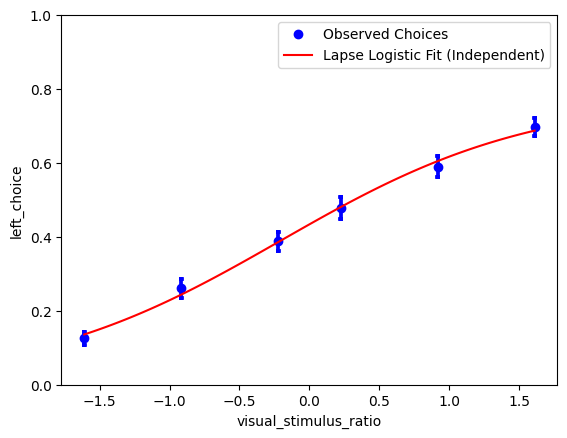

In [44]:
df_test = dft.get_performance_by_difficulty_ratio(df_test)
plots.psychometric_plot(df_test, x = 'visual_stimulus_ratio', y = 'left_choice')


<Axes: xlabel='visual_stimulus_diff_binned', ylabel='left_choice'>

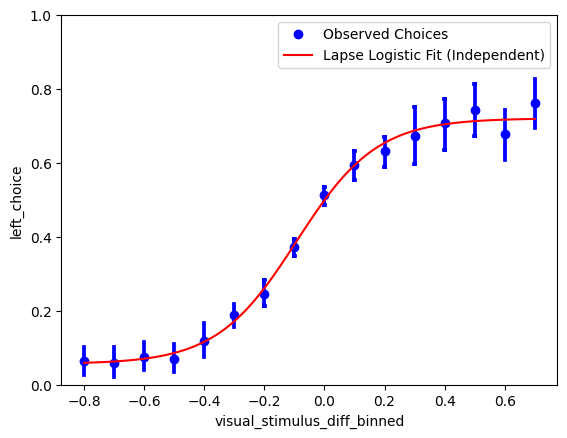

In [45]:
df_test = dft.get_performance_by_difficulty_diff(df_test)
plots.psychometric_plot(df_test, x = 'visual_stimulus_diff', y = 'left_choice', valueType = 'continue', )

GLM comparation

the following cell can be use to evaluate the model. It will be useful when comparing different models

In [46]:
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from scipy.optimize import minimize
import numpy as np

# Define the lapse logistic function with independent lapses for left and right
def lapse_logistic_independent(params, x, y):
    lapse_left, lapse_right, beta, x0 = params
    # Ensure lapse rates are within [0, 0.5]
    lapse_left = np.clip(lapse_left, 0, 0.5)
    lapse_right = np.clip(lapse_right, 0, 0.5)
    # Predicted probabilities
    p_left = lapse_left + (1 - lapse_left - lapse_right) / (1 + np.exp(-beta * (x - x0)))
    # Negative log-likelihood
    nll = -np.sum(y * np.log(p_left) + (1 - y) * np.log(1 - p_left))
    return nll

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation
log_losses = []

# Perform cross-validation
for train_index, test_index in kf.split(df_test):
    # Split the data
    x_train, x_test = df_test['visual_stimulus_ratio'].values[train_index], df_test['visual_stimulus_ratio'].values[test_index]
    y_train, y_test = df_test['left_choice'].values[train_index], df_test['left_choice'].values[test_index]
    
    # Initial parameter guesses: [lapse_left, lapse_right, beta, x0]
    initial_params = [0.05, 0.05, 1, 0]
    
    # Fit the model on the training data
    result = minimize(
        lapse_logistic_independent,
        initial_params,
        args=(x_train, y_train),
        bounds=[(0, 0.5), (0, 0.5), (None, None), (None, None)]
    )
    
    # Extract fitted parameters
    lapse_left, lapse_right, beta, x0 = result.x
    
    # Generate predictions on the test data
    p_left_test = lapse_left + (1 - lapse_left - lapse_right) / (1 + np.exp(-beta * (x_test - x0)))
    
    # Calculate log loss for the test data
    loss = log_loss(y_test, p_left_test)
    log_losses.append(loss)

# Print cross-validation results
print(f"Cross-Validation Log Losses: {log_losses}")
print(f"Mean Log Loss: {np.mean(log_losses)}")
print(f"Standard ratio of Log Loss: {np.std(log_losses)}")

Cross-Validation Log Losses: [0.5956259610754516, 0.5965169299545352, 0.6129185367433484, 0.5938089695091081, 0.6020083675685833]
Mean Log Loss: 0.6001757529702053
Standard ratio of Log Loss: 0.006933405200063407


weight and stats for the different predictors:
- visual stimulus ratio (you call it deviation)
- visual stimulus diff. Nuo: change to "total intensity on left port"
- port where the animal is coming from
- interactions
- Nuo: add another regressor: the previous correct choice

We can play around with this things

In [85]:
df_new_for_fit = dft.parameters_for_fit(df_test)
results, _ = utils.logi_model_fit(df_new_for_fit, X = ['abs_visual_stimulus_ratio',
                      'previous_port_before_stimulus_numeric',
                      'visual_ratio_diff_interact',
                      'previous_choice_left_correct',
                      'previous_choice_right_wrong',
                      'previous_choice_left', 
                      'visual_ratio_bright_interact'
                          ], y = 'left_choice')
print(results)

Optimization terminated successfully.
         Current function value: 0.539326
         Iterations 7


TypeError: cannot unpack non-iterable Summary object

correct choice as output

In [142]:
df_new_for_fit = dft.parameters_for_fit(df_test)
results = utils.logi_model_fit(df_new_for_fit, X = ['abs_visual_stimulus_ratio',
                                                    'wrong_bright', 
                                                    # 'wrong_bright_zscore',
                                                    'same_choice_correctPre', 
                                                    # 'diff_choice_wrongPre', 
                                                    'same_choice_previous', 
                                                    'previous_correct', 
                                                    # 'previous_choice_same_correct'
                                                    ], y = 'correct_numeric')
print(results) 

Optimization terminated successfully.
         Current function value: 0.602391
         Iterations 5
(<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 7145
Model:                          Logit   Df Residuals:                     7139
Method:                           MLE   Df Model:                            5
Date:                Fri, 27 Jun 2025   Pseudo R-squ.:                 0.05523
Time:                        16:06:44   Log-Likelihood:                -4304.1
converged:                       True   LL-Null:                       -4555.7
Covariance Type:            nonrobust   LLR p-value:                1.592e-106
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
intercept                    

auditory

Correct wrong psychometric curve

Text(0.5, 1.0, 'Right Choice Previous')

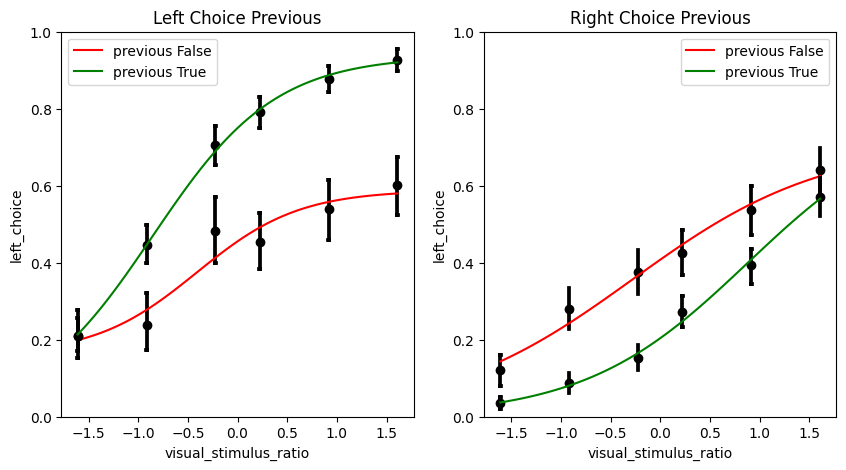

In [144]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i, linecolor in zip(df_new_for_fit[df_new_for_fit['previous_choice_left'] == 1].groupby('previous_correct'), ['red', 'green']):
    plots.psychometric_plot(df = i[1], 
                            x = 'visual_stimulus_ratio', 
                            y = 'left_choice', 
                            ax=ax[0],
                            point_kwargs={'marker': 'o', 'color': 'k', 'label': ''},
                            line_kwargs={'color': linecolor, 'label': 'previous ' + str(i[0])}
                                        )

for i, linecolor in zip(df_new_for_fit[df_new_for_fit['previous_choice_left'] == 0].groupby('previous_correct'), ['red', 'green']):
    plots.psychometric_plot(df = i[1], 
                            x = 'visual_stimulus_ratio', 
                            y = 'left_choice', 
                            ax=ax[1],
                            point_kwargs={'marker': 'o', 'color': 'k', 'label': ''},
                            line_kwargs={'color': linecolor, 'label': 'previous ' + str(i[0])}
                                        )
ax[0].legend()
ax[0].set_title("Left Choice Previous")
ax[1].legend()
ax[1].set_title("Right Choice Previous")

Text(0.5, 1.0, 'Incorrect Choice Previous')

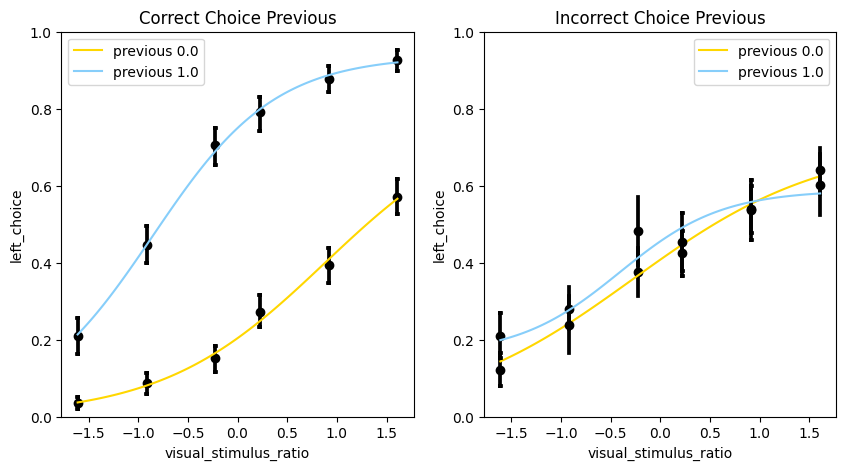

In [146]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i, linecolor in zip(df_new_for_fit[df_new_for_fit['previous_correct'] == True].groupby('previous_choice_left'), ['gold', 'lightskyblue']):
    plots.psychometric_plot(df = i[1], 
                            x = 'visual_stimulus_ratio', 
                            y = 'left_choice', 
                            ax=ax[0],
                            point_kwargs={'marker': 'o', 'color': 'k', 'label': ''},
                            line_kwargs={'color': linecolor, 'label': 'previous ' + str(i[0])}
                        )

for i, linecolor in zip(df_new_for_fit[df_new_for_fit['previous_correct'] == False].groupby('previous_choice_left'), ['gold', 'lightskyblue']):
    plots.psychometric_plot(df = i[1], 
                            x = 'visual_stimulus_ratio', 
                            y = 'left_choice', 
                            ax=ax[1],
                            point_kwargs={'marker': 'o', 'color': 'k', 'label': ''},
                            line_kwargs={'color': linecolor, 'label': 'previous ' + str(i[0])}
                        )
ax[0].legend()
ax[0].set_title("Correct Choice Previous")
ax[1].legend()
ax[1].set_title("Incorrect Choice Previous")

Matrix format

In [ ]:
# let's use the absolute value of the lowest visual stimulus as a proxy for the brightness of the visual stimulus
df_test['visual_stimulus_lowest'] = df_test['visual_stimulus'].apply(lambda x: abs(eval(x)[0]) if eval(x)[0] < eval(x)[1] else abs(eval(x)[1]))
# create 10 bins for the absolute value of the lowest visual stimulus
min_value = df_test['visual_stimulus_lowest'].min()
max_value = df_test['visual_stimulus_lowest'].max()
bins = np.linspace(min_value, max_value, 11)
df_test['visual_stimulus_lowest_binned'] = pd.cut(df_test['visual_stimulus_lowest'], bins=bins, labels=[f"{b:.2f}" for b in bins[:-1]])
# create a pivot table with the visual stimulus ratio and absolute value of the lowest visual stimulus
pivot_table_abs = df_test.pivot_table(
    index='visual_stimulus_lowest_binned',
    columns='visual_stimulus_ratio',
    values='left_choice',
    aggfunc='mean',
    observed=True
)
# plot the heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(pivot_table_abs, cmap='coolwarm', annot=True, fmt=".2f", cbar_kws={'label': 'Probability of Left Choice'})
plt.xlabel("Visual Stimulus ratio")
plt.ylabel("Absolute Value of Lowest Visual Stimulus")
plt.title("Heatmap of Probability of Left Choice")
# rotate the y-axis labels
plt.yticks(rotation=0)
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
# transform visual_stimulus_lowest_binned to a numeric value for plotting
df_test['visual_stimulus_lowest_binned_num'] = pd.to_numeric(df_test['visual_stimulus_lowest_binned'], errors='coerce')

# make two plots, one for when the animals comes from the left and one for when it comes from the right
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
# Plot for when the animal comes from the left
for ax, side in zip(axs.ravel(), ['left', 'right']):
    df_side = df_test[df_test['previous_port_before_stimulus'] == side]
    for i in df_side.groupby('visual_stimulus_ratio'):
        df_i = i[1].sort_values(by='visual_stimulus_lowest_binned_num')
        # drop nan
        df_i = df_i.dropna(subset=['visual_stimulus_lowest_binned_num'])
        X = df_i['visual_stimulus_lowest_binned_num'].values.reshape(-1, 1)
        y = df_i['left_choice'].values.astype(int)
        model = LogisticRegression()
        model.fit(X, y)
        y_pred = model.predict(X)
        y_prob = model.predict_proba(X)[:, 1]
        ax.plot(X, y_prob, label=f"Visual Stimulus ratio: {i[0]}")
    ax.set_xlabel("Absolute Value of Lowest Visual Stimulus")
    ax.set_ylabel("Probability of Left Choice")
    ax.legend()
    ax.set_title(f"Last Choice Before Stimulus: {side.capitalize()}")
plt.show()

Fit the lapse model independently considering previous choices

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

colors = ["blue", "orange"]

for color, side in zip(colors, ['left', 'right']):
    df_side = df_test[df_test['previous_port_before_stimulus'] == side]
    # Fit the model
    x = df_side['visual_stimulus_ratio'].values
    y = df_side['left_choice'].values
    result = minimize(
        lapse_logistic_independent,
        initial_params,
        args=(x, y),
        bounds=[(0, 0.5), (0, 0.5), (None, None), (None, None)]
    )

    # Extract fitted parameters
    lapse_left, lapse_right, beta, x0 = result.x
    print(f"Side: {side}, Lapse Left: {lapse_left}, Lapse Right: {lapse_right}, Slope (Beta): {beta}, PSE (x0): {x0}")

    # Generate predictions
    xs = np.linspace(df_side['visual_stimulus_ratio'].min(), df_side['visual_stimulus_ratio'].max(), 100)
    p_left = lapse_left + (1 - lapse_left - lapse_right) / (1 + np.exp(-beta * (xs - x0)))

    # Plot the fitted curve

    sns.pointplot(
        x='visual_stimulus_ratio',
        y='left_choice',
        data=df_side,
        estimator=lambda x: np.mean(x),
        color=color,
        markers='o',
        errorbar=("ci", 95),
        ax=ax,
        label=f'Choices when coming from {side}',
        native_scale=True,
        linestyles='',
    )
    ax.plot(xs, p_left, color=color, label='Lapse Logistic Fit')
    ax.set_xlabel("Visual Stimulus ratio")
    ax.set_ylabel("Probability of Left Choice")
    plt.title(f"Psychometric Curves")
    ax.legend()
plt.show()

I kept what you did for comparison here

In [ ]:
# It is interesting to compare the effects of the relative difference between the two visual stimuli,
# and the absolute difference between them.

# Maybe what we can do is to train another logistic regression model, adding as well the absolute difference
# between the two visual stimuli, and see how it affects the probability of a left choice.
# Do you know what I mean?

for i in df_test.groupby('visual_stimulus_ratio'):
    df_i = i[1].sort_values(by='visual_stimulus_diff')
    X = df_i['visual_stimulus_diff'].values.reshape(-1, 1)
    y = df_i['left_choice'].values.astype(int)
    model = LogisticRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]
    plt.plot(X, y_prob, label=f"Visual Stimulus ratio: {i[0]}")
    plt.legend()
plt.xlabel("Visual Stimulus Difference")
plt.ylabel("Probability of Left Choice")
plt.show()

Multiple animals analysis


In [5]:
df_dic = {}
for mouse in animals:
    local_path = Path(utils.get_outpath()) / Path(tv_projects[1]) / Path("sessions") / Path(mouse)
    # create the directory if it doesn't exist
    local_path.mkdir(parents=True, exist_ok=True)
    # download the session data
    utils.rsync_session_data(
        project_name=tv_projects[1],
        animal=mouse,
        local_path=str(local_path),
        credentials=utils.get_idibaps_cluster_credentials(),
    )
    # load the data
    df_dic[mouse] = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")

receiving incremental file list
ACV001.csv

sent 88,030 bytes  received 2,234,651 bytes  273,256.59 bytes/sec
total size is 172,174,333  speedup is 74.13
receiving incremental file list

sent 20 bytes  received 69 bytes  59.33 bytes/sec
total size is 156,998,655  speedup is 1,764,029.83
receiving incremental file list
ACV003.csv

sent 82,808 bytes  received 1,540,440 bytes  249,730.46 bytes/sec
total size is 149,418,896  speedup is 92.05
receiving incremental file list
ACV004.csv

sent 70,467 bytes  received 770,725 bytes  152,944.00 bytes/sec
total size is 105,970,540  speedup is 125.98
receiving incremental file list
ACV005.csv

sent 69,844 bytes  received 1,088,931 bytes  210,686.36 bytes/sec
total size is 106,128,335  speedup is 91.59
receiving incremental file list
ACV006.csv

sent 76,459 bytes  received 923,925 bytes  153,905.23 bytes/sec
total size is 125,073,052  speedup is 125.03
receiving incremental file list
ACV007.csv

sent 70,285 bytes  received 634,989 bytes  128,231.64 

In [6]:
df_dic_hard = {}
for df_name, df in zip(df_dic.keys(), df_dic.values()):
    if 'TwoAFC_visual_hard' in df["current_training_stage"].unique():
        df = df[df["current_training_stage"] == "TwoAFC_visual_hard"]
        df = dft.get_performance_by_difficulty_ratio(df)
        df = dft.get_performance_by_difficulty_diff(df)
        df_dic_hard[df_name] = df

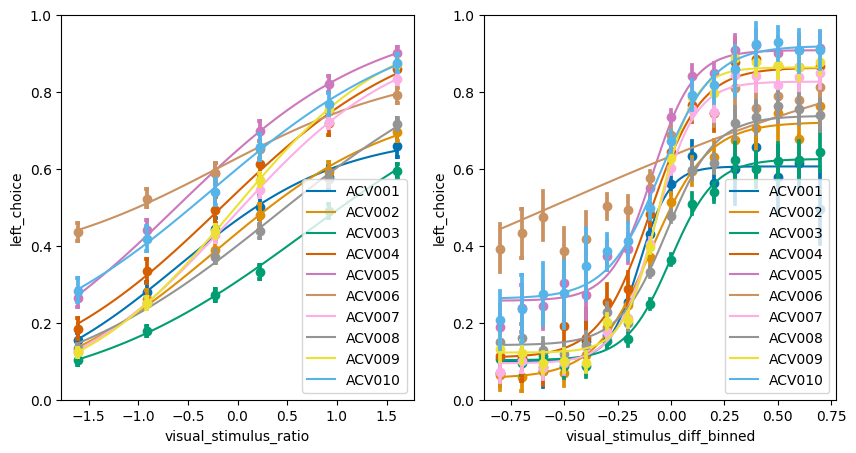

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for df_name, df, color in zip(df_dic_hard.keys(), df_dic_hard.values(), sns.color_palette("colorblind", len(df_dic_hard))):
    plots.psychometric_plot(df, x='visual_stimulus_ratio', y='left_choice', ax = ax[0], point_kwargs={'color': color, 'label' : ''}, line_kwargs={'color': color, 'label': df_name})
    plots.psychometric_plot(df, x='visual_stimulus_diff', y='left_choice', ax = ax[1], point_kwargs={'color': color, 'label' : ''}, line_kwargs={'color': color, 'label': df_name}, valueType='continue')
plt.show()

In [ ]:

X = ['abs_visual_stimulus_ratio',
    'previous_port_before_stimulus_numeric',
    'visual_ratio_diff_interact',
    'previous_choice_left_correct',
    'previous_choice_right_wrong',
    'previous_choice_left', 
    'visual_ratio_bright_interact'
    ]
df_leftChoice_model_p = pd.DataFrame()
df_leftChoice_model_coef = pd.DataFrame()
df_leftChoice_model_z =  pd.DataFrame()
for df_name, df, color in zip(df_dic_hard.keys(), df_dic_hard.values(), sns.color_palette("colorblind", len(df_dic_hard))):
    df_for_fit = dft.parameters_for_fit(df)
    # normalize the X columns in the df_for_fit by zscore
    df_for_fit[X] = df_for_fit[X].apply(lambda x: (x - x.mean()) / x.std())
    _, model = utils.logi_model_fit(df_for_fit, X=X, y='left_choice')
    # plot the results
    df_leftChoice_model_p[df_name] = model.pvalues
    df_leftChoice_model_coef[df_name] = model.params
    df_leftChoice_model_z[df_name] = model.tvalues


Optimization terminated successfully.
         Current function value: 0.596558
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.539326
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.486080
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.538953
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.486827
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.553889
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.522940
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.478730
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.545858
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.489004
  

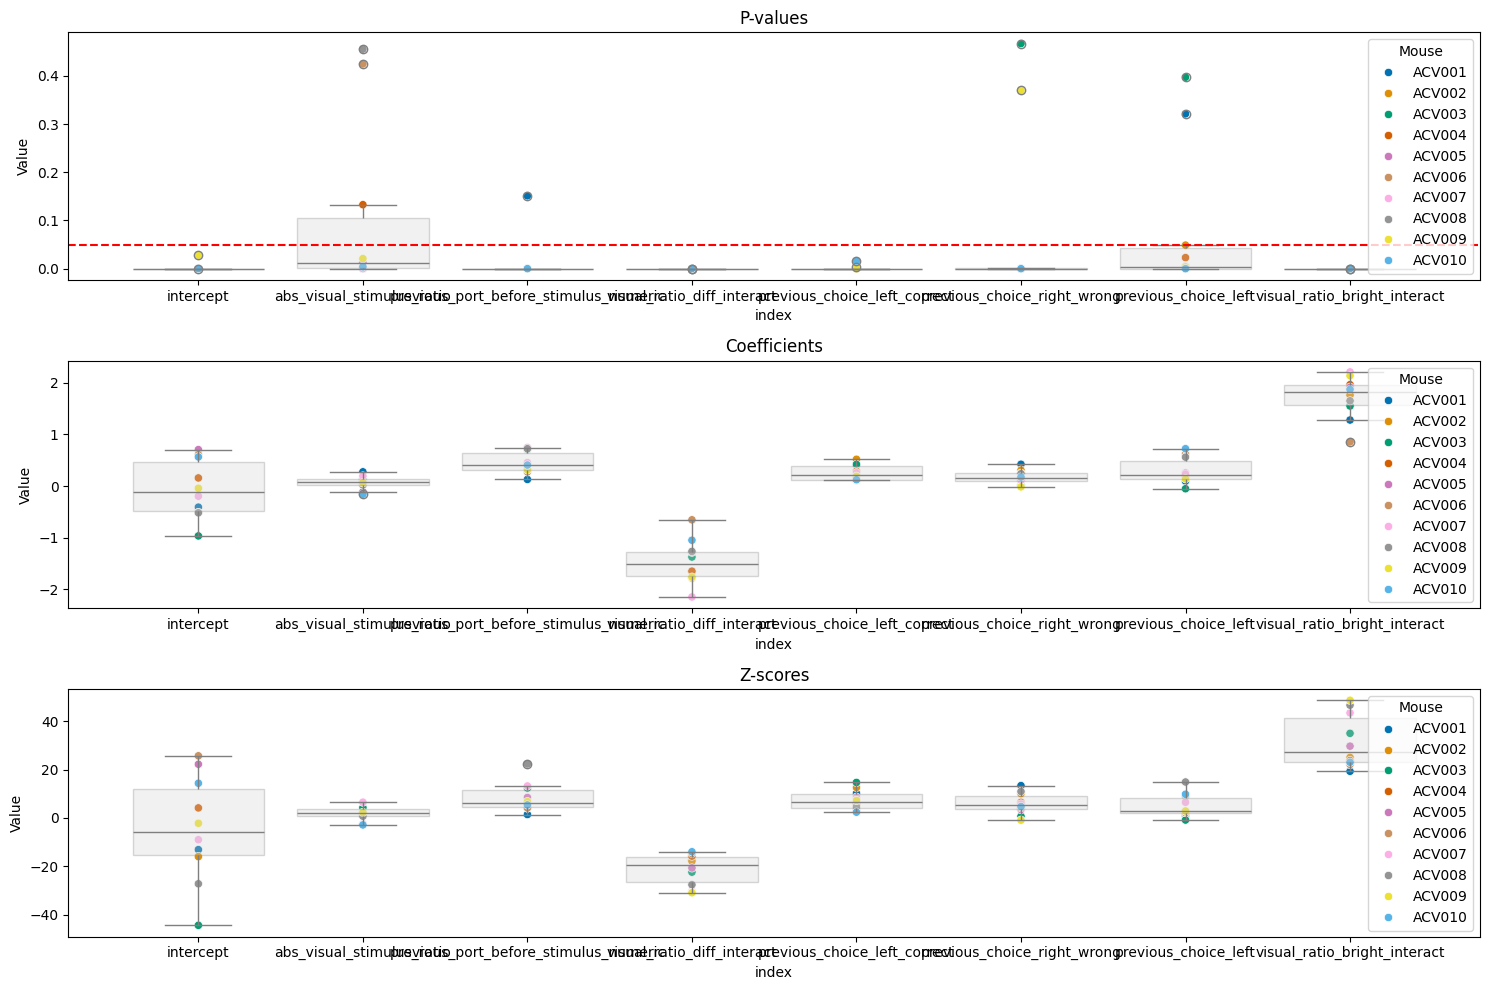

In [ ]:
# plot the p-values coefficients and z
fig, ax = plt.subplots(3, 1, figsize=(15, 10))
df_leftChoice_model_p.index = ['intercept'] + X
df_leftChoice_model_coef.index = ['intercept'] + X
df_leftChoice_model_z.index = ['intercept'] + X
df_leftChoice_model_p_long = df_leftChoice_model_p.reset_index().melt(id_vars='index', var_name='Mouse', value_name='Value')
sns.boxplot(data=df_leftChoice_model_p_long, x='index', y='Value', ax=ax[0], color='lightgrey', boxprops=dict(alpha=0.3))
sns.scatterplot(data=df_leftChoice_model_p_long, ax=ax[0], x='index', y='Value', hue='Mouse', palette='colorblind')
ax[0].axhline(y=0.05, color='red', linestyle='--', label='Significance Threshold (0.05)')
df_leftChoice_model_coef_long = df_leftChoice_model_coef.reset_index().melt(id_vars='index', var_name='Mouse', value_name='Value')
sns.boxplot(data=df_leftChoice_model_coef_long, x='index', y='Value', ax=ax[1], color='lightgrey', boxprops=dict(alpha=0.3))
sns.scatterplot(data=df_leftChoice_model_coef_long, ax=ax[1], x='index', y='Value', hue='Mouse', palette='colorblind')
df_leftChoice_model_z_long = df_leftChoice_model_z.reset_index().melt(id_vars='index', var_name='Mouse', value_name='Value')
sns.boxplot(data=df_leftChoice_model_z_long, x='index', y='Value', ax=ax[2], color='lightgrey', boxprops=dict(alpha=0.3))
sns.scatterplot(data=df_leftChoice_model_z_long, ax=ax[2], x='index', y='Value', hue='Mouse', palette='colorblind')
ax[0].set_title("P-values")
ax[1].set_title("Coefficients")
ax[2].set_title("Z-scores")
plt.tight_layout()
plt.show()

In [ ]:
df_new_for_fit = dft.parameters_for_fit(df_test)
results = utils.logi_model_fit(df_new_for_fit, X = ['abs_visual_stimulus_ratio',
                                                    'wrong_bright', 
                                                    # 'wrong_bright_zscore',
                                                    'same_choice_correctPre', 
                                                    # 'diff_choice_wrongPre', 
                                                    'same_choice_previous', 
                                                    'previous_correct', 
                                                    # 'previous_choice_same_correct'
                                                    ], y = 'correct_numeric')
print(results) 

In [117]:
X = ['abs_visual_stimulus_ratio',
    'wrong_bright', 
    # 'wrong_bright_zscore',
    'same_choice_correctPre', 
    # 'diff_choice_wrongPre', 
    'same_choice_previous', 
    'previous_correct', 
    # 'previous_choice_same_correct'
    ]
df_correctChoice_model_p = pd.DataFrame()
df_correctChoice_model_coef = pd.DataFrame()
df_correctChoice_model_z =  pd.DataFrame()
for df_name, df, color in zip(df_dic_hard.keys(), df_dic_hard.values(), sns.color_palette("colorblind", len(df_dic_hard))):
    df_for_fit = dft.parameters_for_fit(df)
    _, model = utils.logi_model_fit(df_for_fit, X=X, y='correct_numeric')
    # plot the results
    df_correctChoice_model_p[df_name] = model.pvalues
    df_correctChoice_model_coef[df_name] = model.params
    df_correctChoice_model_z[df_name] = model.tvalues

Optimization terminated successfully.
         Current function value: 0.630624
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602391
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621241
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569108
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.572923
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.650746
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548962
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.599125
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.529574
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.591565
  

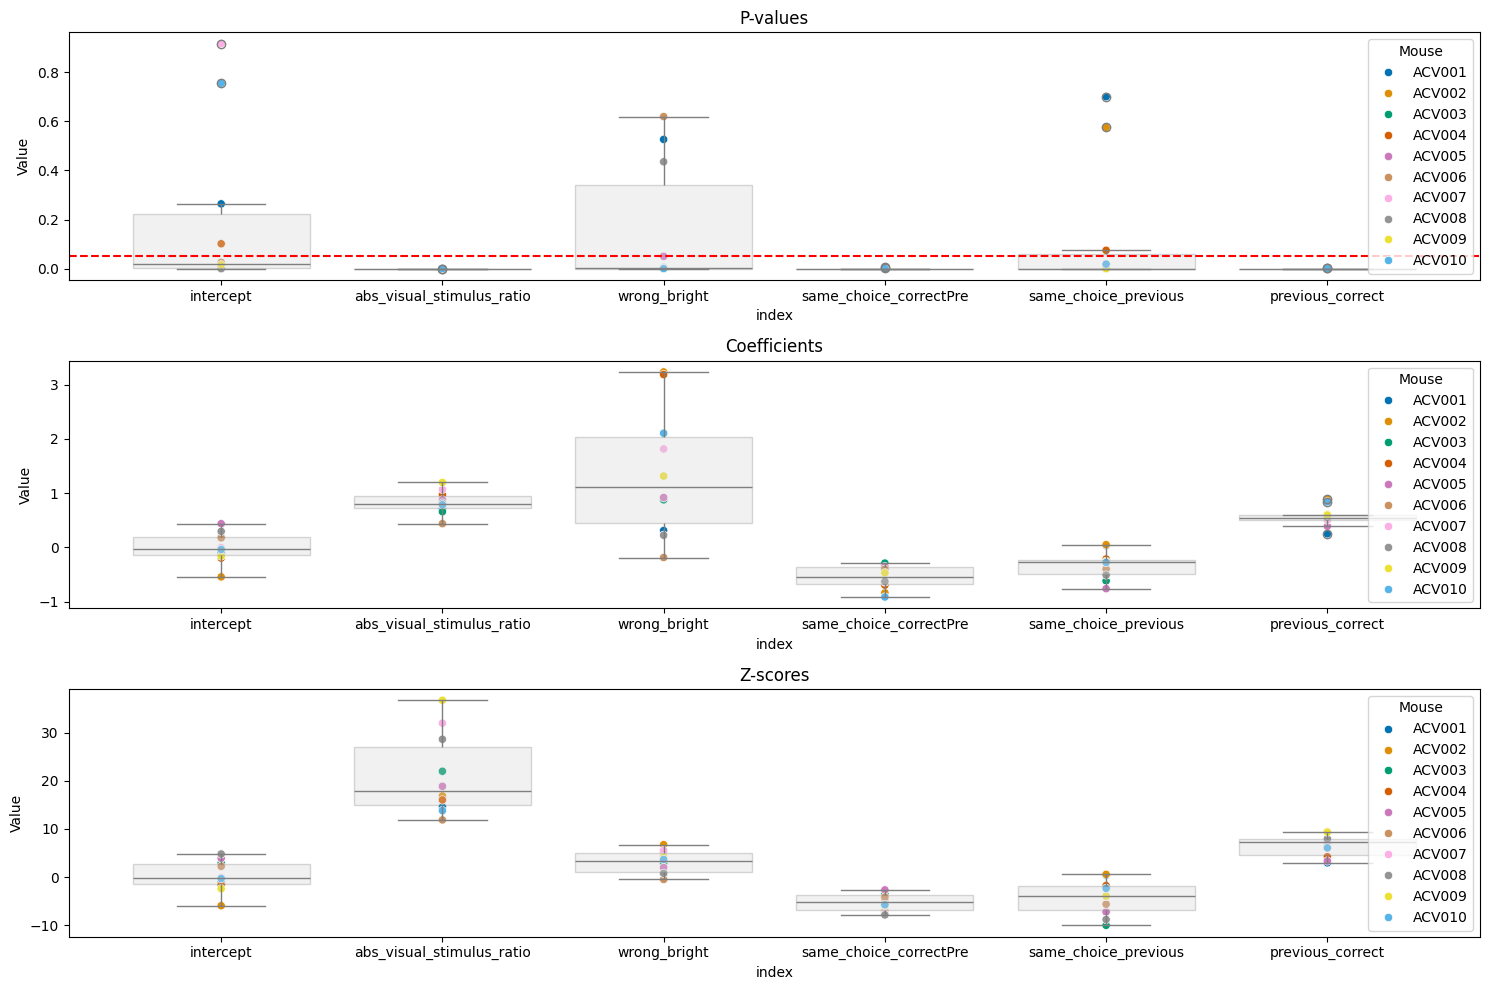

In [ ]:
# plot the p-values coefficients and z
fig, ax = plt.subplots(3, 1, figsize=(15, 10))
df_correctChoice_model_p.index = ['intercept'] + X
df_correctChoice_model_coef.index = ['intercept'] + X
df_correctChoice_model_z.index = ['intercept'] + X
df_correctChoice_model_p_long = df_correctChoice_model_p.reset_index().melt(id_vars='index', var_name='Mouse', value_name='Value')
sns.boxplot(data=df_correctChoice_model_p_long, x='index', y='Value', ax=ax[0], color='lightgrey', boxprops=dict(alpha=0.3))
sns.scatterplot(data=df_correctChoice_model_p_long, ax=ax[0], x='index', y='Value', hue='Mouse', palette='colorblind')
ax[0].axhline(y=0.05, color='red', linestyle='--', label='Significance Threshold (0.05)')
df_correctChoice_model_coef_long = df_correctChoice_model_coef.reset_index().melt(id_vars='index', var_name='Mouse', value_name='Value')
sns.boxplot(data=df_correctChoice_model_coef_long, x='index', y='Value', ax=ax[1], color='lightgrey', boxprops=dict(alpha=0.3))
sns.scatterplot(data=df_correctChoice_model_coef_long, ax=ax[1], x='index', y='Value', hue='Mouse', palette='colorblind')
df_correctChoice_model_z_long = df_correctChoice_model_z.reset_index().melt(id_vars='index', var_name='Mouse', value_name='Value')
sns.boxplot(data=df_correctChoice_model_z_long, x='index', y='Value', ax=ax[2], color='lightgrey', boxprops=dict(alpha=0.3))
sns.scatterplot(data=df_correctChoice_model_z_long, ax=ax[2], x='index', y='Value', hue='Mouse', palette='colorblind')
ax[0].set_ylabel("P-values")
ax[1].set_ylabel("Coefficients")
ax[2].set_ylabel("Z-scores")
plt.tight_layout()
plt.show()

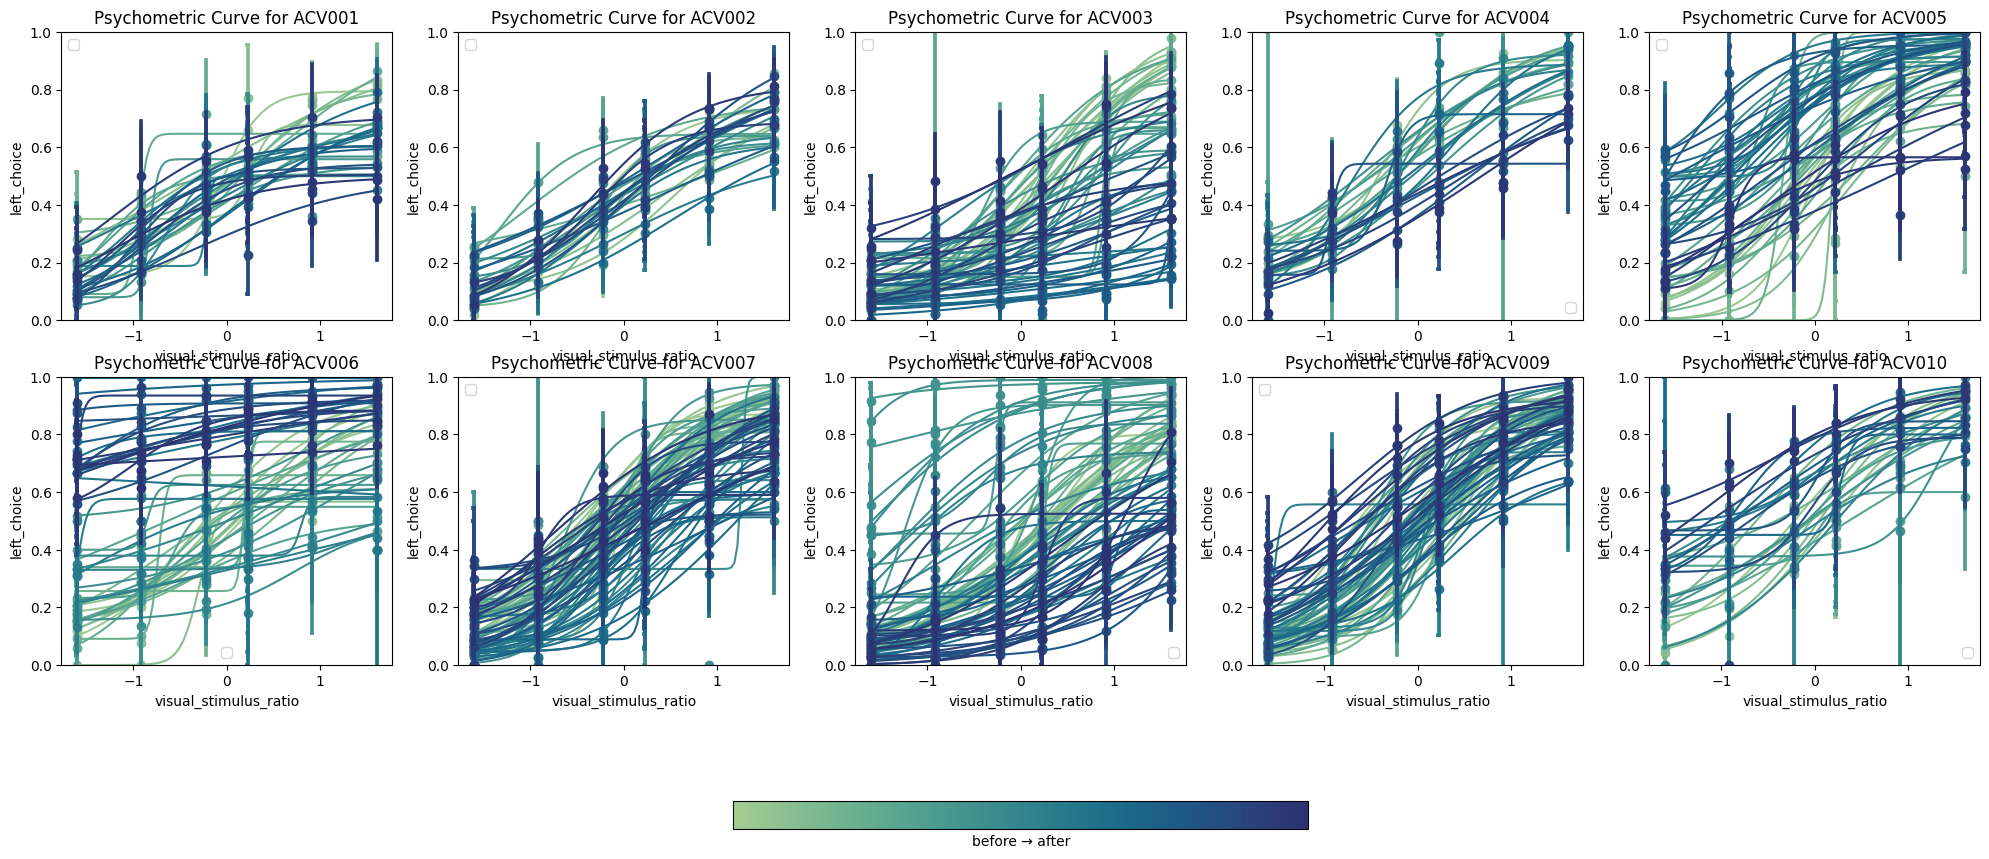

In [95]:
fig, ax = plt.subplots(2, 5, figsize=(20, 10))
for df_name, df, n in zip(df_dic_hard.keys(), df_dic_hard.values(), range(len(df_dic_hard))):
    row = n // 5
    col = n % 5
    for session, color in zip(df['session'].unique(), sns.color_palette("crest", len(df['session'].unique()))):
        df_session = df[df['session'] == session]
        plots.psychometric_plot(df_session, x='visual_stimulus_ratio', y='left_choice',ax=ax[row, col], point_kwargs={'color': color, 'label' : ''}, line_kwargs={'color': color, 'label': ''})
    ax[row, col].set_title(f"Psychometric Curve for {df_name}")
plt.tight_layout()
# Add a colorbar to indicate the session
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=sns.color_palette("crest", as_cmap=True)), orientation='horizontal', ax=ax, shrink=0.3)
cbar.set_ticks([])
cbar.set_label('before → after')
plt.show()

In [ ]:
X = ['abs_visual_stimulus_ratio',
    'previous_port_before_stimulus_numeric',
    'visual_ratio_diff_interact',
    'previous_choice_left_correct',
    'previous_choice_right_wrong',
    'previous_choice_left', 
    'visual_ratio_bright_interact'
    ]
dic_leftChoice_model_p = {}
dic_leftChoice_model_coef = {}
dic_leftChoice_model_z = {}
for df_name, df, n in zip(df_dic_hard.keys(), df_dic_hard.values(), range(len(df_dic_hard))):
    row = n // 5
    col = n % 5
    df_leftChoice_model_p = pd.DataFrame()
    df_leftChoice_model_coef = pd.DataFrame()
    df_leftChoice_model_z =  pd.DataFrame()
    # create a session group column
    unique_sessions = df['session'].unique()
    session_to_group = {session: i // 10 for i, session in enumerate(unique_sessions)} # this groups sessions in groups of 10
    df['session_group'] = df['session'].map(session_to_group)
    for session, color in zip(df['session_group'].unique(), sns.color_palette("crest", len(df['session'].unique()))):
        df_session = df[df['session_group'] == session]
        df_session_for_fit = dft.parameters_for_fit(df_session)
        # # normalize the X columns in the df_session_for_fit by zscore
        # df_session_for_fit[X] = df_session_for_fit[X].apply(lambda x: (x - x.mean()) / x.std())
        _, model = utils.logi_model_fit(df_session_for_fit, X=X, y='left_choice', method='powell')
        df_leftChoice_model_p[session] = model.pvalues
        df_leftChoice_model_coef[session] = model.params
        df_leftChoice_model_z[session] = model.tvalues
    df_leftChoice_model_p.index = ['intercept'] + X
    df_leftChoice_model_coef.index = ['intercept'] + X
    df_leftChoice_model_z.index = ['intercept'] + X
    dic_leftChoice_model_p[df_name] = df_leftChoice_model_p.T
    dic_leftChoice_model_coef[df_name] = df_leftChoice_model_coef.T
    dic_leftChoice_model_z[df_name] = df_leftChoice_model_z.T

Optimization terminated successfully.
         Current function value: 0.624170
         Iterations: 9
         Function evaluations: 677
Optimization terminated successfully.
         Current function value: 0.587621
         Iterations: 8
         Function evaluations: 598
Optimization terminated successfully.
         Current function value: 0.523744
         Iterations: 10
         Function evaluations: 773
Optimization terminated successfully.
         Current function value: 0.533333
         Iterations: 11
         Function evaluations: 855
Optimization terminated successfully.
         Current function value: 0.517302
         Iterations: 10
         Function evaluations: 771
Optimization terminated successfully.
         Current function value: 0.557716
         Iterations: 13
         Function evaluations: 990
Optimization terminated successfully.
         Current function value: 0.488669
         Iterations: 10
         Function evaluations: 759
Optimization terminated succe

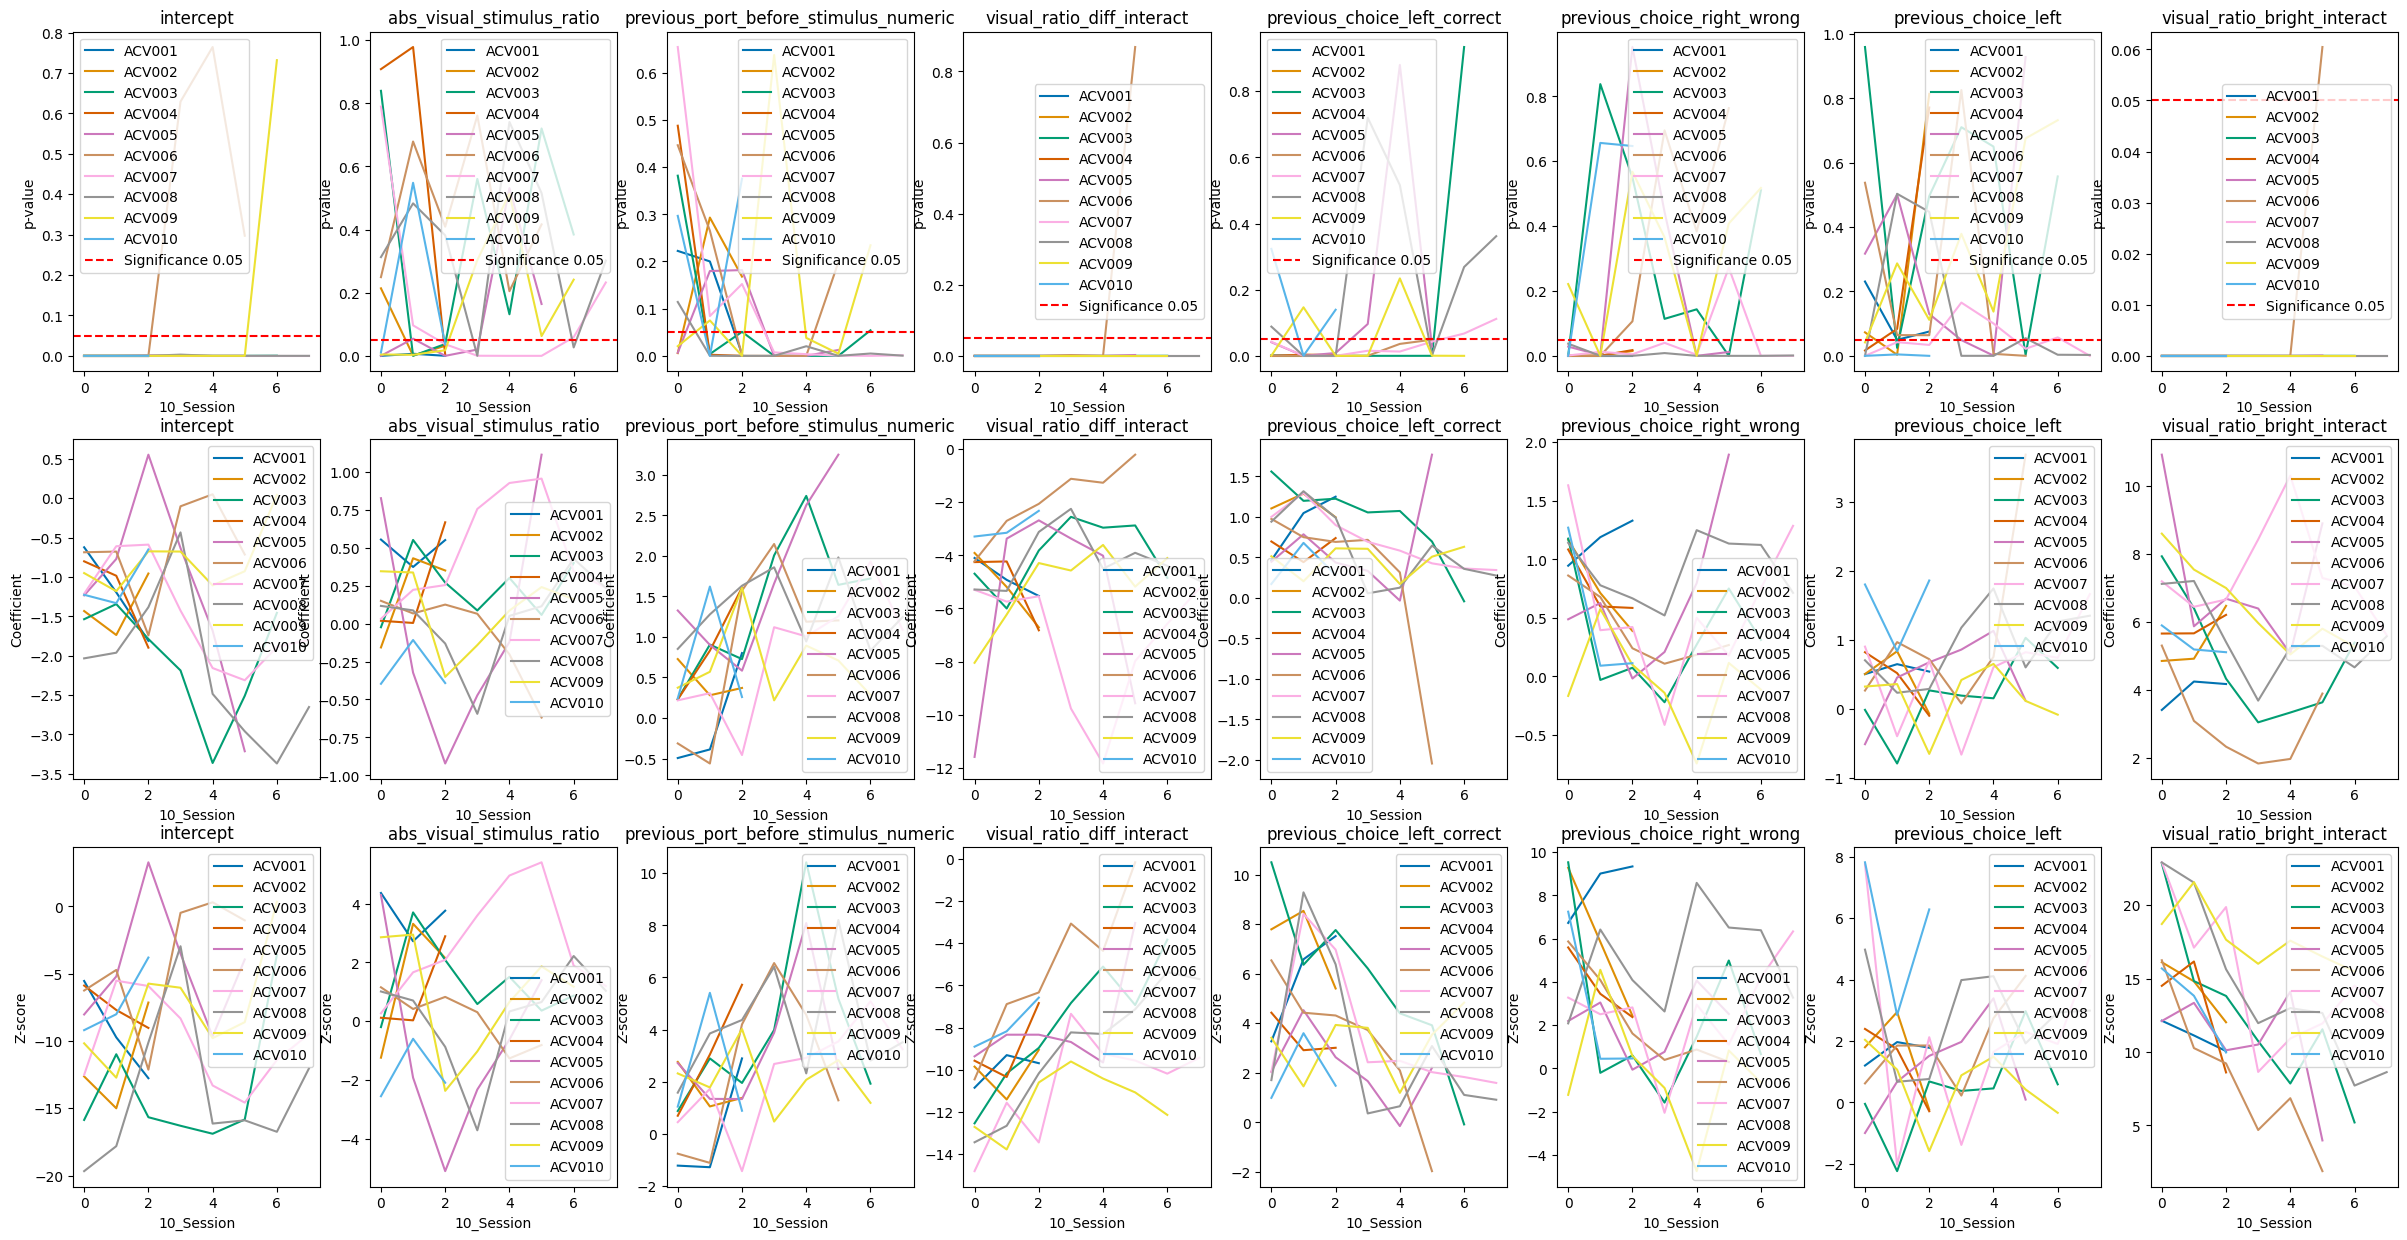

In [135]:
fig, ax = plt.subplots(3, len(X)+1, figsize=(30, 15))
for n, param in zip(range(len(X)+1), ['intercept'] + X):
    for mouse, color in zip(dic_leftChoice_model_p, sns.color_palette("colorblind", len(dic_leftChoice_model_p))):
        ax[0, n].plot(dic_leftChoice_model_p[mouse].index, dic_leftChoice_model_p[mouse].iloc[:, n], label=mouse, color=color)
    ax[0, n].set_title(param)
    ax[0, n].set_xlabel("10_Session")
    ax[0, n].set_ylabel("p-value")
    ax[0, n].axhline(y=0.05, color='red', linestyle='--', label='Significance 0.05')
    ax[0, n].legend()
for n, param in zip(range(len(X)+1), ['intercept'] + X):
    for mouse, color in zip(dic_leftChoice_model_coef, sns.color_palette("colorblind", len(dic_leftChoice_model_coef))):
        ax[1, n].plot(dic_leftChoice_model_coef[mouse].index, dic_leftChoice_model_coef[mouse].iloc[:, n], label=mouse, color=color)
    ax[1, n].set_title(param)
    ax[1, n].set_xlabel("10_Session")
    ax[1, n].set_ylabel("Coefficient")
    ax[1, n].legend()
for n, param in zip(range(len(X)+1), ['intercept'] + X):
    for mouse, color in zip(dic_leftChoice_model_z, sns.color_palette("colorblind", len(dic_leftChoice_model_z))):
        ax[2, n].plot(dic_leftChoice_model_z[mouse].index, dic_leftChoice_model_z[mouse].iloc[:, n], label=mouse, color=color)
    ax[2, n].set_title(param)
    ax[2, n].set_xlabel("10_Session")
    ax[2, n].set_ylabel("Z-score")
    ax[2, n].legend()

In [138]:
X = ['abs_visual_stimulus_ratio',
    'wrong_bright', 
    # 'wrong_bright_zscore',
    'same_choice_correctPre', 
    # 'diff_choice_wrongPre', 
    'same_choice_previous', 
    'previous_correct', 
    # 'previous_choice_same_correct', 
    'roa_choice_numeric'
    ]
dic_correctChoice_model_p = {}
dic_correctChoice_model_coef = {}
dic_correctChoice_model_z = {}
for df_name, df, n in zip(df_dic_hard.keys(), df_dic_hard.values(), range(len(df_dic_hard))):
    row = n // 5
    col = n % 5
    df_correctChoice_model_p = pd.DataFrame()
    df_correctChoice_model_coef = pd.DataFrame()
    df_correctChoice_model_z =  pd.DataFrame()
    # create a session group column
    unique_sessions = df['session'].unique()
    session_to_group = {session: i // 10 for i, session in enumerate(unique_sessions)} # this groups sessions in groups of 10
    df['session_group'] = df['session'].map(session_to_group)
    for session, color in zip(df['session_group'].unique(), sns.color_palette("crest", len(df['session'].unique()))):
        df_session = df[df['session_group'] == session]
        df_session_for_fit = dft.parameters_for_fit(df_session)
        # # normalize the X columns in the df_session_for_fit by zscore
        # df_session_for_fit[X] = df_session_for_fit[X].apply(lambda x: (x - x.mean()) / x.std())
        _, model = utils.logi_model_fit(df_session_for_fit, X=X, y='correct_numeric', method='powell')
        df_correctChoice_model_p[session] = model.pvalues
        df_correctChoice_model_coef[session] = model.params
        df_correctChoice_model_z[session] = model.tvalues
    df_correctChoice_model_p.index = ['intercept'] + X
    df_correctChoice_model_coef.index = ['intercept'] + X
    df_correctChoice_model_z.index = ['intercept'] + X
    dic_correctChoice_model_p[df_name] = df_correctChoice_model_p.T
    dic_correctChoice_model_coef[df_name] = df_correctChoice_model_coef.T
    dic_correctChoice_model_z[df_name] = df_correctChoice_model_z.T

Optimization terminated successfully.
         Current function value: 0.618070
         Iterations: 7
         Function evaluations: 486
Optimization terminated successfully.
         Current function value: 0.629224
         Iterations: 7
         Function evaluations: 482
Optimization terminated successfully.
         Current function value: 0.639140
         Iterations: 7
         Function evaluations: 474
Optimization terminated successfully.
         Current function value: 0.605980
         Iterations: 12
         Function evaluations: 830
Optimization terminated successfully.
         Current function value: 0.610615
         Iterations: 12
         Function evaluations: 825
Optimization terminated successfully.
         Current function value: 0.574739
         Iterations: 18
         Function evaluations: 1236
Optimization terminated successfully.
         Current function value: 0.503642
         Iterations: 13
         Function evaluations: 911
Optimization terminated succe

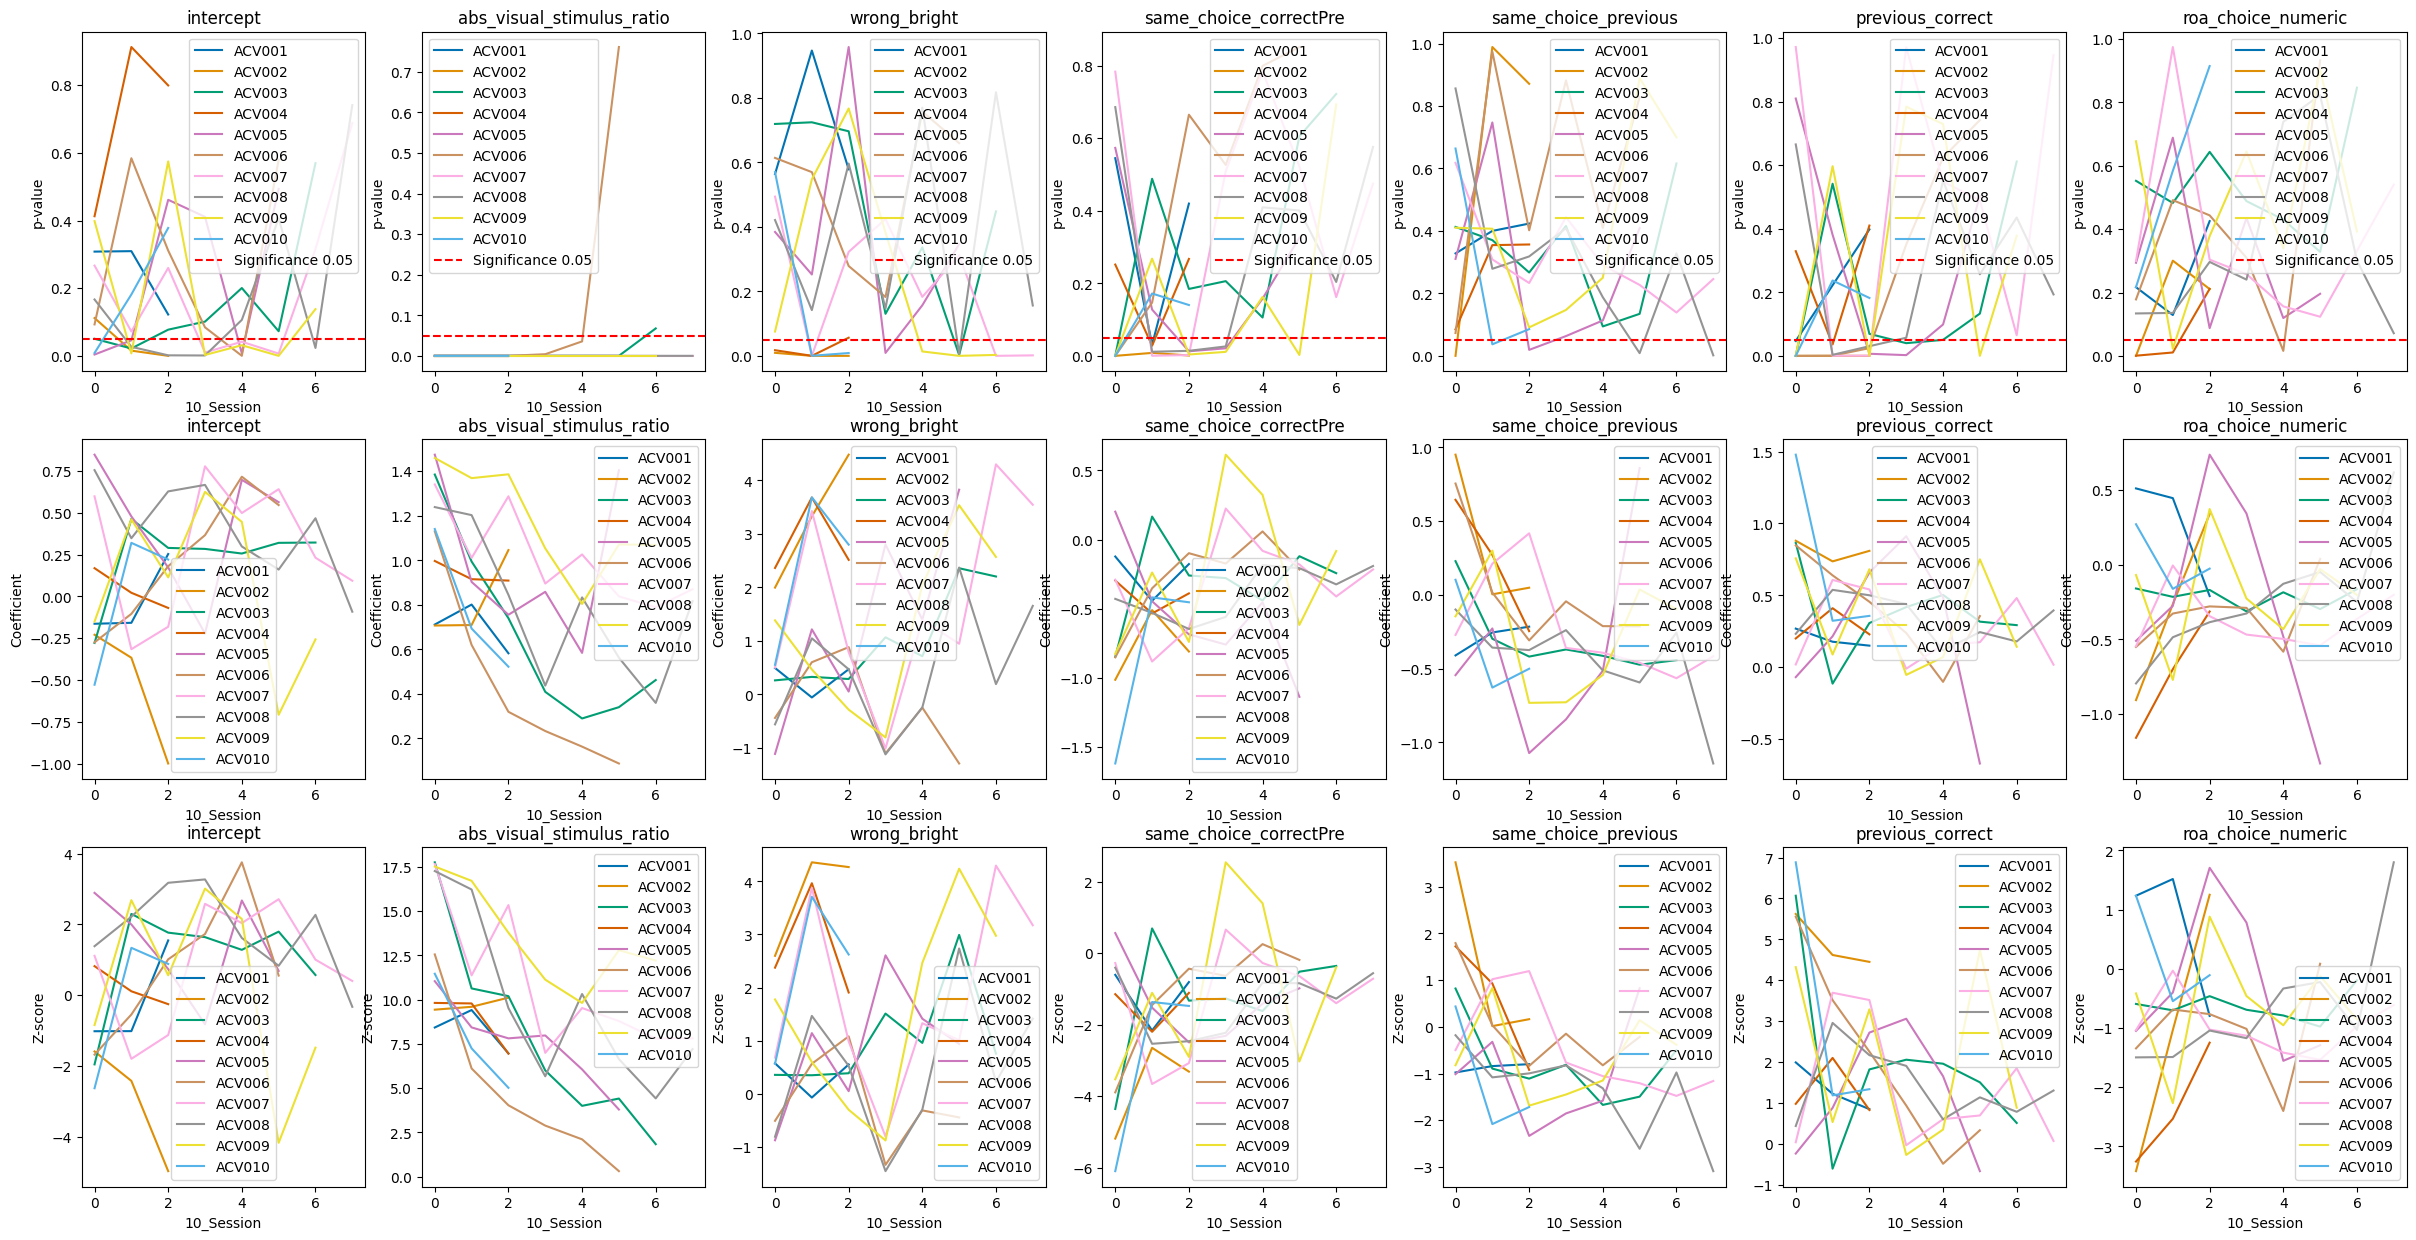

In [139]:
fig, ax = plt.subplots(3, len(X)+1, figsize=(30, 15))
for n, param in zip(range(len(X)+1), ['intercept'] + X):
    for mouse, color in zip(dic_correctChoice_model_p, sns.color_palette("colorblind", len(dic_correctChoice_model_p))):
        ax[0, n].plot(dic_correctChoice_model_p[mouse].index, dic_correctChoice_model_p[mouse].iloc[:, n], label=mouse, color=color)
    ax[0, n].set_title(param)
    ax[0, n].set_xlabel("10_Session")
    ax[0, n].set_ylabel("p-value")
    ax[0, n].axhline(y=0.05, color='red', linestyle='--', label='Significance 0.05')
    ax[0, n].legend()
for n, param in zip(range(len(X)+1), ['intercept'] + X):
    for mouse, color in zip(dic_correctChoice_model_coef, sns.color_palette("colorblind", len(dic_correctChoice_model_coef))):
        ax[1, n].plot(dic_correctChoice_model_coef[mouse].index, dic_correctChoice_model_coef[mouse].iloc[:, n], label=mouse, color=color)
    ax[1, n].set_title(param)
    ax[1, n].set_xlabel("10_Session")
    ax[1, n].set_ylabel("Coefficient")
    ax[1, n].legend()
for n, param in zip(range(len(X)+1), ['intercept'] + X):
    for mouse, color in zip(dic_correctChoice_model_z, sns.color_palette("colorblind", len(dic_correctChoice_model_z))):
        ax[2, n].plot(dic_correctChoice_model_z[mouse].index, dic_correctChoice_model_z[mouse].iloc[:, n], label=mouse, color=color)
    ax[2, n].set_title(param)
    ax[2, n].set_xlabel("10_Session")
    ax[2, n].set_ylabel("Z-score")
    ax[2, n].legend()